In [119]:
import os
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import random
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('./autoencoder_loss')

TRAIN_PATH = './dataset/train/'
PROLIV_PATH = './dataset/proliv/'
TEST_IMGS_PATH = './dataset/test/imgs/'
TEST_ANNOT_PATH = './dataset/test/test_annotation.txt'

BATCH_SIZE = 512
EPOCHS = 15

Приведем все изображения из тренировочной выборки к единому размеру.

In [120]:
train_images_names = os.listdir(TRAIN_PATH)

widths = []
heights = []

for train_image_name in train_images_names:
    width, height = Image.open(os.path.join(TRAIN_PATH, train_image_name)).size
    widths.append(width)
    heights.append(height)

print(f'Единый размер: {(np.median(widths).astype("int"), np.median(heights).astype("int"))}')

Единый размер: (48, 27)


In [121]:
TENSOR_SIZE = (27, 48)

class ImagesDataset(Dataset):
    def __init__(self, images_folder_path, transform=None):
        images_paths = os.listdir(images_folder_path)
        images_paths = list(map(lambda image_path : os.path.join(images_folder_path, image_path), images_paths))
        
        self.images_paths = images_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.images_paths[idx])
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [122]:
train_dataset = ImagesDataset(
    images_folder_path=TRAIN_PATH,
      transform=transforms.Compose(
            [
              transforms.CenterCrop((TENSOR_SIZE[0] // 2, TENSOR_SIZE[1] // 2)),
              transforms.ToTensor(),
            ]
        )
    )


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Архитектура автоэнкодера

In [123]:
class Autoencoder(nn.Module):
    def __init__(self, img_height, img_width, latent_dim, channels=3, loss=nn.MSELoss(), threshold=None):
        super().__init__()
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels
        self.loss = loss
        self.threshold = threshold

        self.encoder = torch.nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(img_width * img_height * 3, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, latent_dim)
        )
         
        self.decoder = torch.nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, img_width * img_height * 3)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.reshape((-1, self.channels, self.img_height, self.img_width))
    
    def classify(self, x):
        if self.threshold is None:
            raise ValueError("Не установлен порог для классификации")
        decoded_x = self.forward(x)
        loss = self.loss(decoded_x, x)
        if loss >= self.threshold:
            return 1
        else:
            return 0

#### Обучение автоэнкодера

In [124]:
ae = Autoencoder(TENSOR_SIZE[0] // 2, TENSOR_SIZE[1] // 2, latent_dim=32)
 
loss_function = nn.MSELoss()
 
optimizer = Adam(ae.parameters(), lr = 1e-5)

In [125]:
train_losses = []

for epoch in range(1, EPOCHS+1):

    print(f'Epoch {epoch}/{EPOCHS}')

    train_epoch_losses = []
    for images in tqdm(train_dataloader, unit='batch'):

        optimizer.zero_grad()
                
        ae_images = ae(images)
        loss = loss_function(ae_images, images)

        loss.backward()
        optimizer.step()

        train_epoch_losses.append(loss.item())

    epoch_loss = np.mean(train_epoch_losses)
    train_losses.append(epoch_loss)
    writer.add_scalar('autoencoder loss', epoch_loss, epoch)

writer.flush()
    

Epoch 1/15


100%|██████████| 20/20 [00:03<00:00,  5.60batch/s]


Epoch 2/15


100%|██████████| 20/20 [00:01<00:00, 11.16batch/s]


Epoch 3/15


100%|██████████| 20/20 [00:01<00:00, 17.55batch/s]


Epoch 4/15


100%|██████████| 20/20 [00:01<00:00, 19.44batch/s]


Epoch 5/15


100%|██████████| 20/20 [00:01<00:00, 13.83batch/s]


Epoch 6/15


100%|██████████| 20/20 [00:01<00:00, 10.19batch/s]


Epoch 7/15


100%|██████████| 20/20 [00:01<00:00, 17.57batch/s]


Epoch 8/15


100%|██████████| 20/20 [00:01<00:00, 11.81batch/s]


Epoch 9/15


100%|██████████| 20/20 [00:01<00:00, 13.42batch/s]


Epoch 10/15


100%|██████████| 20/20 [00:01<00:00, 13.74batch/s]


Epoch 11/15


100%|██████████| 20/20 [00:01<00:00, 19.34batch/s]


Epoch 12/15


100%|██████████| 20/20 [00:01<00:00, 13.07batch/s]


Epoch 13/15


100%|██████████| 20/20 [00:01<00:00, 19.41batch/s]


Epoch 14/15


100%|██████████| 20/20 [00:01<00:00, 19.15batch/s]


Epoch 15/15


100%|██████████| 20/20 [00:02<00:00,  6.79batch/s]


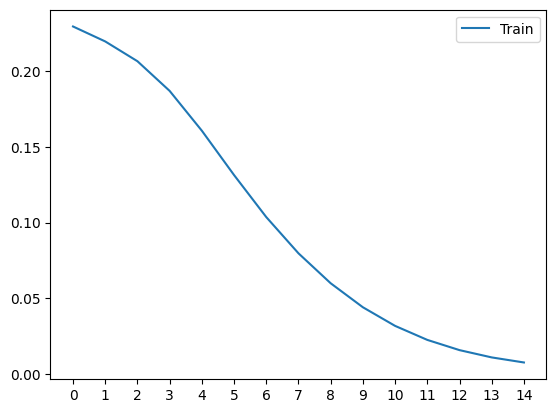

In [126]:
plt.plot(train_losses, label = "Train")
plt.xticks(range(EPOCHS))
plt.legend() 
plt.show()

Посмотрим на распределения ошибок для обучающей выборки и для проливов

In [127]:
train_losses_per_image = []

for image in DataLoader(train_dataset, batch_size=1):       
    ae_image = ae(image)
    loss = loss_function(ae_image, image)
    train_losses_per_image.append(loss.item())

proliv_dataset = ImagesDataset(
    PROLIV_PATH, 
    transform=transforms.Compose(
            [
              transforms.CenterCrop((TENSOR_SIZE[0] // 2, TENSOR_SIZE[1] // 2)),
              transforms.ToTensor(),
            ]
        )
)

proliv_losses_per_image = []

for image in DataLoader(proliv_dataset, batch_size=1):       
    ae_image = ae(image)
    loss = loss_function(ae_image, image)
    proliv_losses_per_image.append(loss.item())


Возьмем семпл из обучающий выборки по размеру равный размеру датасета с проливами.

In [128]:
random.shuffle(train_losses_per_image)

train_losses_sample = train_losses_per_image[:len(proliv_losses_per_image)]

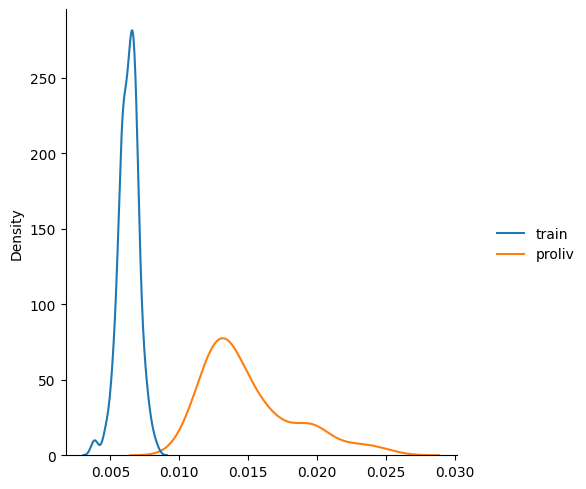

In [129]:
sns.displot({"train" : train_losses_sample, "proliv" : proliv_losses_per_image}, kind='kde')
plt.show()

Как и ожидалось, ошибка для проливов больше. MSE = 0.009 кажется неплохим вариантом для выбора в качестве порога согласно визуализации.

Установим порог классификации для автоэнкодера.

In [135]:
ae.threshold = 0.009

Классифицируем изображения из теста.

In [136]:
transform=transforms.Compose(
            [
              transforms.CenterCrop((TENSOR_SIZE[0] // 2, TENSOR_SIZE[1] // 2)),
              transforms.ToTensor(),
            ]
        )

In [137]:
with open(TEST_ANNOT_PATH) as f:
    lines = f.readlines()

y_true = np.zeros(len(lines))
y_pred = np.zeros(len(lines))

for i, line in enumerate(lines):
    image_name, label = line.split()
    y_true[i] = int(label)
    image = Image.open(os.path.join(TEST_IMGS_PATH, image_name))
    transformed_image = transform(image)
    transformed_image = torch.unsqueeze(transformed_image, 0)
    y_pred[i] = ae.classify(transformed_image)

In [138]:
cm = confusion_matrix(y_true, y_pred)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

precision = tp / (tp + fp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True positive rate: {round(tpr * 100, 2)} %")
print(f"True negative rate: {round(tnr * 100, 2)} %")
print(f"Precision: {round(precision * 100, 2)} %")

True positive rate: 77.52 %
True negative rate: 97.9 %
Precision: 56.5 %
